# ADMM使用(TV正則化)

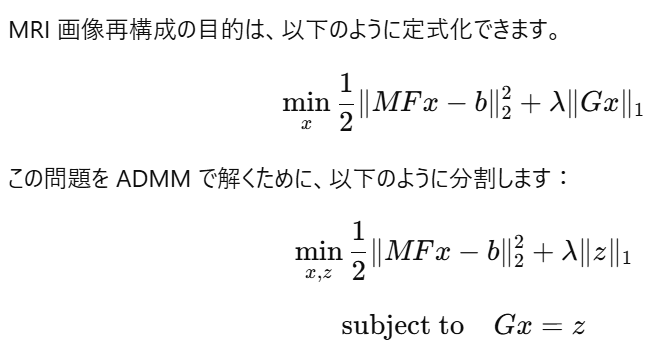

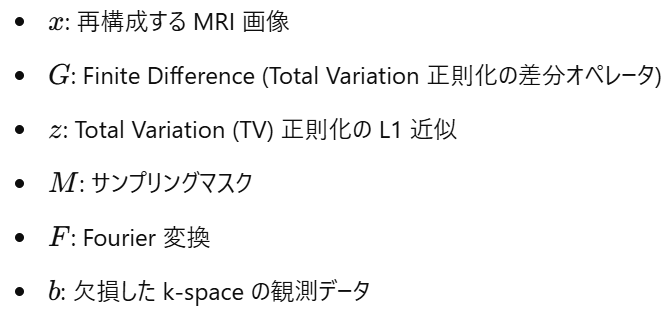

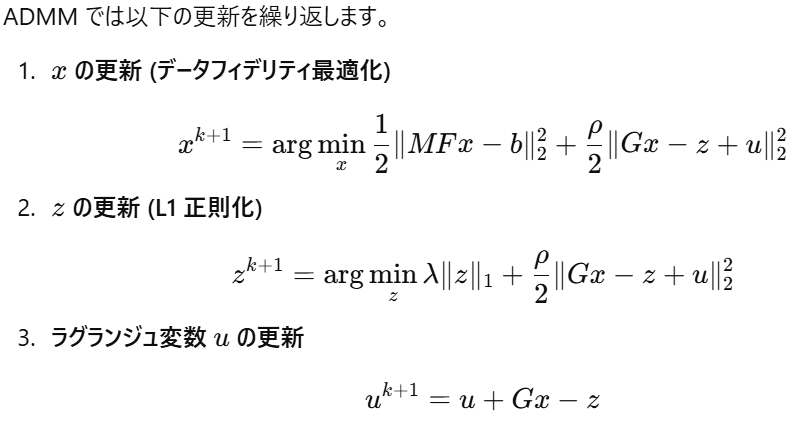

# min_Lにconjugate gradientを用いる

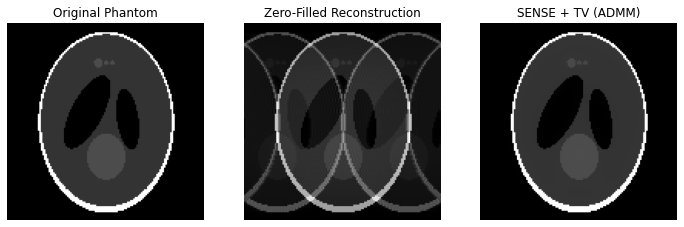

In [1]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# **2. コイル感度マップの生成 (birdcage model, 4 coils)**
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# **3. k-space の計算 (各コイルごとに感度をかけて Fourier 変換)**
ksp = np.array([sp.fft(phantom * mps[i], axes=(-1, -2)) for i in range(num_coils)])

# **4. 1D undersampling マスク（位相エンコード方向のみ間引く）**
mask = np.ones(img_shape)
mask[:, ::3] = 0  # 3倍加速
ksp_sampled = ksp * mask  # 各コイルに適用

# **5. SENSE の線形オペレータ**
F = sp.linop.FFT(ksp.shape, axes=(-1, -2))  # Fourier 変換
S = sp.linop.Multiply(img_shape, mps)  # 感度マップ適用
P = sp.linop.Multiply(ksp.shape, mask)  # サンプリングマスク適用
A = P * F * S  # SENSE の forward モデル

# **6. TV 正則化オペレータ**
G = sp.linop.FiniteDifference(img_shape, axes=[0, 1])  # TV の差分演算

# **7. ADMM パラメータ**
lambda_tv = 0.01  # TV 正則化の強さ
rho = 0.1  # ADMM のペナルティ係数
max_iter = 50  # ADMM の最大反復回数

# **8. 変数の初期化**
x = np.zeros(img_shape, dtype=np.complex128)  # 主変数
z = np.zeros(G.oshape, dtype=np.complex128)  # TV 正則化のスパース変数
u = np.zeros(G.oshape, dtype=np.complex128)  # ラグランジュ乗数

# **9. ADMM の反復更新**
for i in range(max_iter):
    # **x の更新 (CG 法)**
    AHA = A.H * A + rho * G.H * G  # 正規化された演算子
    b = A.H(ksp_sampled) + rho * G.H * (z - u)  # 右辺

    cg_solver = sp.alg.ConjugateGradient(AHA, b, x, max_iter=10)
    while not cg_solver.done():
        cg_solver.update()

    # **z の更新 (TV 正則化, ソフトしきい値処理)**
    z = sp.prox.L1Reg(G.oshape, lambda_tv / rho)(1.0, G * x + u)

    # **u の更新 (ラグランジュ乗数)**
    u += G * x - z

# **10. 結果を取得**
reconstructed_img = np.abs(x)  # 絶対値を取って実画像にする

# **11. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(np.sum(sp.ifft(ksp_sampled, axes=(-1, -2)), axis=0)), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("SENSE + TV (ADMM)")
axs[2].axis("off")

plt.show()
